# Forecasting Banana Prices

## Table of Contents¶

1. Introduction
2. Install and Import Packages
3. Access Data from FRED
4. Explore Data (Plot, ACF, AD Fuller)
5. **Identification**
<br>5.1. Seasonality
<br>5.2. Stationarize
<br>5.3. Identify AR Order
<br>5.3.1 PACF
<br>5.3.2. AIC and BIC
<br>5.4. Identify MA Order
6. **Estimation**
<br>6.1. ARIMA
<br>6.2. SARIMA
<br>6.3. SARIMAX
7. **Model Diagnostics**
<br>7.1. Plot Diagnostics
<br>7.2. SARIMAX Summary
<br>7.3. Prediction (In-Sample)
<br>7.3.1. Evaluation
<br>7.4. Forecast (Out-of-Sample)
8. **Production**
9. Future Areas for Improvement


## 1. Introduction

Let's go bananas. Today, we'll predict (in-sample) and forecast (out-of-sample) banana prices using time series data from January 1, 1990 through July 1, 2020 pulled from Federal Reserve Economic Data (FRED) (https://fred.stlouisfed.org/). There, you'll find thousands of macroeconomic and other indicators from around the world if you'd like to explore yourself. 

We'll check for seasonality, transform the data to make it stationary, identify the right orders for AR (autoregressive) and MA (moving average) models and bring them together with ARIMA (autoregressive integrated moving average), SARIMA (seasonal ARIMA), and SARIMAX. We'll fit our model, diagnose it, and use it to make predictions and forecasts (48 months into the future). Building a forecast like this could help wholesale and retail grocers manage inventory and supply chains, set mark-ups, and hedge price fluctuations as well as commodity traders.

To ensure we're building and deploying a high quality model, let's follow the Box-Jenkins framework: 

1. Identification: identify seasonality, stationarize data (check with AD Fuller test), identify orders (p, q) for AR and MA models using ACF, PACF and optimizing AIC and BIC 

2. Estimation: fit ARIMA, SARIMA, and SARIMAX models to estimate AR and MA coefficients

3. Model Diagnostics: plot diagnostics, summary, prediction (in-sample) and evaluation, forecast (out-of-sample)

4. Production: save model using joblib (a set of tools for lightweight Python pipelining, including transparent disk-caching and parallel computing - https://pypi.org/project/joblib/ , https://joblib.readthedocs.io/en/latest/

Our end SARIMAX model features well-behaved residuals with predicted values that differ, on average, by 8% from historical observed values. 

**Future Areas for Improvement**

Context: Get more context from industry experts to understand what constitutes a reasonable forecast error in this specific case. MAPE has its own disadvantages so consider other metrics that industry experts use 

Distribution of Residuals: As we will see with the Jarque-Bera(JB) test and its low (<0.05) p-value Prob(JB) that residuals are not entirely normally distributed. We could also see this in the QQ plot. We could check if removing outliers improves this. 

Stationarity: Our differenced data is only weakly stationary. We can see this in the higher variance in the earlier part of the series. Apply and compare other log transform, n-level differencing, seasonal differencing, or square root adjustments. 

Dynamic prediction and forecast: Incorporated predicted / forecasted values (not just true endogenous values) into prediction and forecast. To do this, set dynamice=True in .get_prediction and .get_forecast, plot, and evaluate. 

Incorporate exogenous variables: Incorporate exogenous variables (e.g., climate, supply shocks, anomalies) into SARIMAX. 

Compare: Compare our forcaste mean prices with futures contracts

Business Translation: Translate the model selection/optimization rationale, evaluation metrics (e.g., MAPE), predictions and forecasts into specific business impact so that it's helpful to understand for a client / stakeholder. 

## 2. Install and Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import date

# Autocorrelation
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Augmented Dickey Fuller (for random walk test)
from statsmodels.tsa.stattools import adfuller

# Trend and seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# ARIMA model
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

# SARIMA model
!pip install pyramid-arima 
from pyramid.arima import auto_arima

# SARIMAX model
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# MSE to evaluate SARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

     |████████████████████████████████| 604kB 8.1MB/s eta 0:00:01


/opt/conda/envs/Python36/lib/python3.6/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [2]:
!pip install pandas-datareader
from pandas_datareader.data import DataReader

     |████████████████████████████████| 112kB 9.4MB/s eta 0:00:01


In [3]:
# Saving and updating model
!pip install joblib
import joblib
from joblib import dump

     |████████████████████████████████| 307kB 10.0MB/s eta 0:00:01


In [4]:
# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

## 3. Access Data from FRED

In [5]:
# Global Price of bananas (USD per metric ton)

# Set start date as January 1, 1990
start = date(1990, 1, 1)

# Set series code, can find on FRED website
series = 'PBANSOPUSDM'

# Import the data
banana = DataReader(series, 'fred', start=start)

In [6]:
# Check first 3 and last 3 rows. We see that it's monthly data starting at the 1st of each month
pd.concat([banana.head(3), banana.tail(3)])

,PBANSOPUSDM
DATE,
1990-01-01,589.700000
1990-02-01,644.900000
1990-03-01,538.500000
2020-05-01,1297.684820
2020-06-01,1298.342541
2020-07-01,1286.331972


In [7]:
# Rename column 
banana.rename(columns={"PBANSOPUSDM":"Banana Price"}, inplace=True)

In [8]:
banana.head()

,Banana Price
DATE,
1990-01-01,589.7
1990-02-01,644.9
1990-03-01,538.5
1990-04-01,584.2
1990-05-01,494.4


In [9]:
# Check info on dataframe, it has a datetime index with 367 monthly data points
banana.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 1990-01-01 to 2020-07-01
Data columns (total 1 columns):
Banana Price    367 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


## 4. Explore Data (plot, ACF, AD Fuller)

### Plot

Text(0, 0.5, '$/Metric Ton')

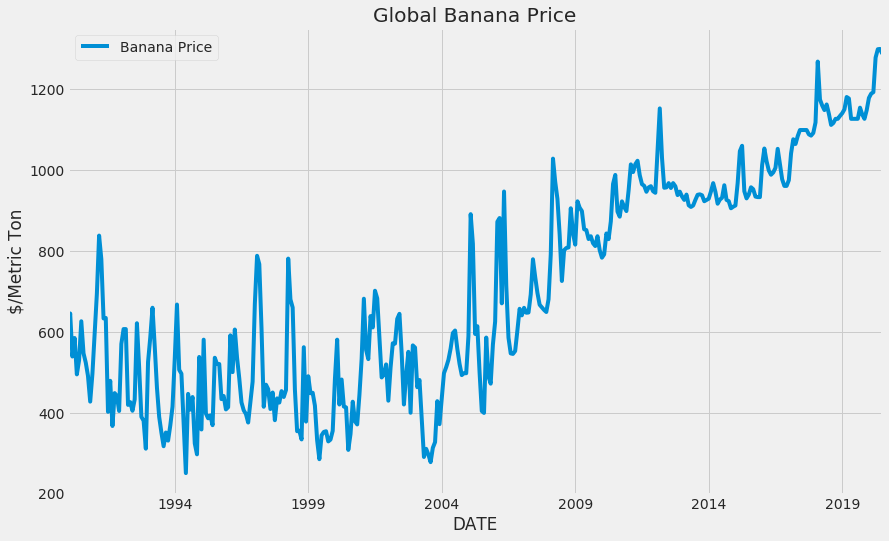

In [10]:
# Plot the price
banana.plot(title='Global Banana Price', figsize=(13,8))
plt.legend(loc='upper left')
plt.ylabel('$/Metric Ton')

### Autocorrelation

In [11]:
# Calcuate monthly change in price
banana['Monthly_Diff'] = banana.diff()

# Calculate and print the autocorrelation lag 1 of monthly changes. Keep in mind autocorr() works only on a Series (we select the column)
banana_autocorrelation_monthly = banana['Monthly_Diff'].autocorr()
print("The autocorrelation of monthly banana price changes is %4.2f" %(banana_autocorrelation_monthly))

The autocorrelation of monthly banana price changes is -0.11


In [12]:
# Convert the monthly data to annual data using .resample
banana_yearly = banana.resample(rule='A').last()

# Calculate and print the autocorrelation lag 1 of yearly changes
banana_yearly_diff = banana_yearly.diff()
banana_autocorrelation_yearly = banana_yearly_diff['Banana Price'].autocorr()
print("The autocorrelation of annual banana price changes is %4.2f" %(banana_autocorrelation_yearly))

The autocorrelation of annual banana price changes is -0.19


### ACF

Banana prices have a negative ACF and are mean-reverting in the short term (monthly).

In [13]:
# We're using the acf function and plotting below. Since we calculated diff, let's remove the NaN values so functions and plots will work properly
banana.dropna(inplace=True)

In [14]:
# Calculate and plot acf 
banana_monthly_acf = acf(banana['Monthly_Diff'])
banana_monthly_acf

array([ 1.00000000e+00, -1.14912248e-01, -2.00476724e-02, -8.37809500e-02,
       -2.73231176e-01,  3.29920150e-02, -1.38459327e-01,  1.18488844e-01,
       -9.76068281e-02, -1.53423838e-02,  7.64885104e-02, -3.64584301e-02,
        1.77816655e-01, -3.30594064e-02, -2.63537583e-02,  4.50602904e-02,
       -2.54944553e-02,  4.12095131e-02, -7.15769429e-02, -1.46761199e-02,
       -7.73016862e-02, -9.47549868e-02,  1.72515624e-02,  5.34624640e-02,
        1.11814103e-01,  1.35499098e-01, -1.73825399e-02, -5.86855756e-02,
       -4.92467324e-04, -1.18556279e-01,  5.22116702e-02, -1.06694274e-01,
       -6.70693180e-02,  5.00336021e-02, -1.21384647e-01,  1.96662486e-01,
        4.92913944e-02,  1.05788404e-01,  6.62041948e-02, -9.73184690e-02,
       -5.56374141e-03])

There's a clear negative autocorrelation with a 1 month lag and intermittent autocorrelations beyond that using a confidence level to 95% (alpha=0.5).

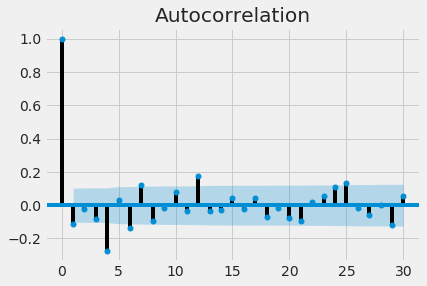

In [15]:
# Plot the acf function
plot_acf(banana['Monthly_Diff'], lags=30, alpha=0.05)
plt.show()

In [16]:
# We're using the acf function and plotting below. Since we calculated diff, let's remove the NaN values so functions and plots will work properly
banana_yearly_diff.dropna(inplace=True)

In [17]:
# Calculate and plot acf array
banana_yearly_acf = acf(banana_yearly_diff['Banana Price'])
banana_yearly_acf

array([ 1.        , -0.18353499, -0.06316629, -0.05644431,  0.18220007,
       -0.20461816,  0.1803907 , -0.05112847,  0.1054808 , -0.17929824,
       -0.03459776,  0.08056533,  0.25070385, -0.22105745, -0.00425224,
        0.01463232,  0.03281216, -0.07309398,  0.00849341, -0.06621472,
       -0.03777545,  0.0158612 , -0.0554151 ,  0.01726339,  0.07364246,
       -0.13551136, -0.01931657,  0.03739239, -0.05403463, -0.05997837])

With a confidence level to 95% (alpha=0.5), in the long term, there is no clear autocorrelation either positive or negative outside of our confidence band so we cannot reject the null hypothesis that there is no autocorrelation between annual banana prices. Looking at autocorrelation alone, it's not possible to forecast banana prices 1 year out. 

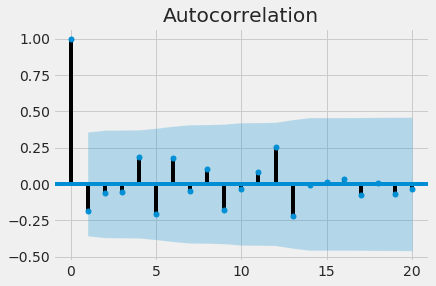

In [18]:
# Plot the acf function
plot_acf(banana_yearly_diff['Banana Price'], lags=20, alpha=0.05)
plt.show()

### AD Fuller Test

In [19]:
# Run the ADF test on banana prices. Printout includes test statistic, p value, and critical values at 1%, 5%, and 10% confidence intervals.
banana_results = adfuller(banana['Banana Price'])
banana_results

(0.4104332048463675,
 0.9818809405311006,
 11,
 354,
 {'1%': -3.4489583388155194,
  '5%': -2.869739378430086,
  '10%': -2.5711381780459},
 3979.962967617813)

The p value is above 0.05 and we cannot reject the null hypothesis that banana prices are a random walk. 

In [20]:
# Print just the p value, which is index value 1
print('The p-value of the test is: ' + str(banana_results[1]))

The p-value of the test is: 0.9818809405311006


The p value is well below 0.05 and we can reject the null hypothesis that banana price changes are a random walk. 

In [21]:
banana_diff_results = adfuller(banana['Monthly_Diff'])
print('The p-value of the test is: ' + str(banana_diff_results[1]))

The p-value of the test is: 1.0218819575068442e-16


## Box-Jenkins Framework

## 5. Identification

### 5.1 Seasonality

Let's check for seasonality and trend in the data using seasonal_decompose. Let's set the model to 'additive' (with 'multiplicative', seasonality increases or decreases with the trend). From the decomposition plot, we see a clear upward trend as well as seasonality with banana prices generally peaking from January to April of each year. 

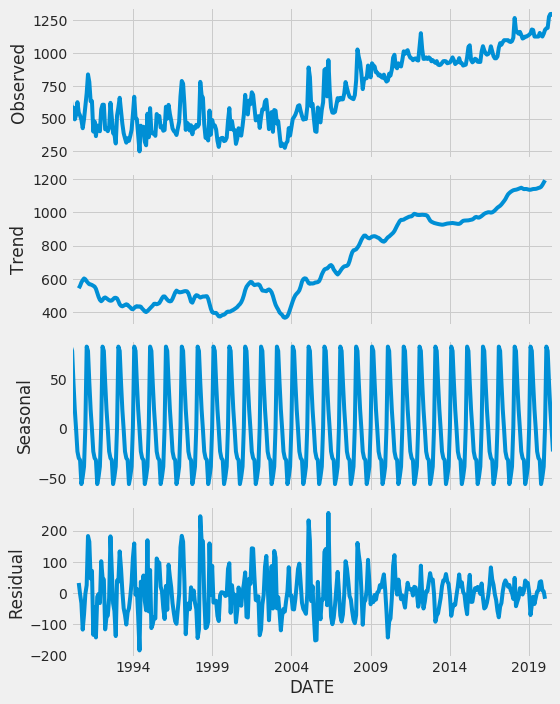

In [22]:
# Decompose banana prices
decompose = seasonal_decompose(banana['Banana Price'], model='additive')

# Set figure size. I used .rcParams to change the matplotlib default because setting figsize wasn't working
plt.rcParams["figure.figsize"] = [8,10]

# Plot decomposition
decompose.plot()
plt.show()

By plotting mean prices by month of the year below, banana prices clearly peak in February-April each year. 

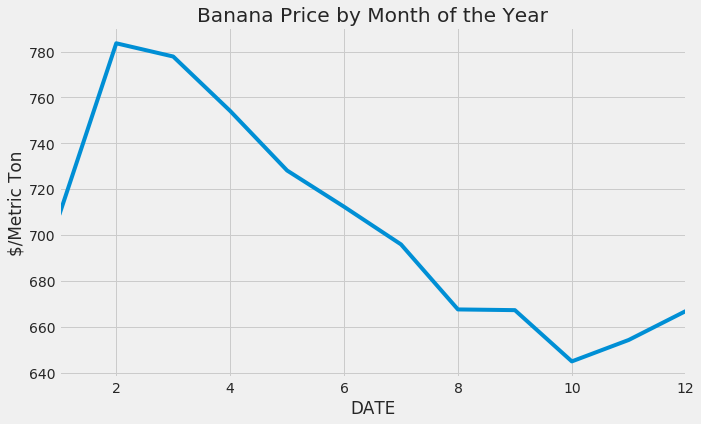

In [53]:
# Group mean prices by month using .index.month and groupby 
index_month = banana.index.month
banana_month = banana.groupby(index_month).mean()

# Plot banana prices by month of the year
plt.figure(figsize=(10,6))
banana_month['Banana Price'].plot(title = 'Banana Price by Month of the Year')
plt.ylabel('$/Metric Ton')
plt.show()

Let's plot an acf to check seasonality. Before we do that, it's important to detrend the data by subtracting the rolling mean to make the seasonality in the acf plot clearer. The acf plot of the detrended data illustrates a seasonality of 12 months. 

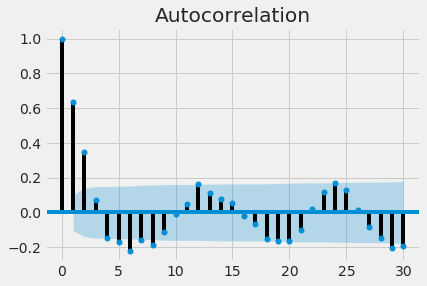

In [23]:
# Detrend banana prices by subtracting the rolling mean of 12 months 
banana_detrend = banana['Banana Price'] - banana['Banana Price'].rolling(12).mean()
banana_detrend = banana_detrend.dropna()

# Plot acf of detrended data
plt.rcParams["figure.figsize"] = [6,4]
plot_acf(banana_detrend, lags=30, alpha=0.05)
plt.show()

### 5.2. Stationarize

In order to use our data to make predictions, it's important to transform the data to make it stationary - that is, removing any trend that the series has (e.g., season, upward, etc) so that it has a constant mean and variance and that the autocovariance between two points does not depend on time. We know that our data is non-stationary because the changes in banana prices do not follow a random walk (AD Fuller test has a low p-value). Transformations such as log transform help to stabilize variance (e.g., with multiplicative seasonality), while n-order and seasonal differencing help to stabilize mean. 

1) Seasonal differencing of 12 months. 

2) N-order differencing on the seasonally adjusted data to stabilize the mean, which shows an upward trend. 

While it looks like the 2nd order differencing gets us a bit closer to stationarity, its autocorrelation plot goes steeply negative right away, meaning that this is likely overdifferenced. As a result, let's stick with the 1st order differencing even though it's not perfect (weakly stationary) (we can see that it's not perfectly stationary as the variance in the plot decreases over time). This means that the 'd' value for the ARIMA model later is 1. 

In [24]:
# Seasonally adjusted log transformed series
banana_adjusted = banana['Banana Price'].diff(12)

In [25]:
# 1st order differencing on seasonally adjusted log transformed data
banana_diff_1 = banana_adjusted.diff()
banana_diff_1.dropna(inplace=True)

# 2nd order differencing on seasonally adjusted log transformed data
banana_diff_2 = banana_adjusted.diff().diff()
banana_diff_2.dropna(inplace=True)

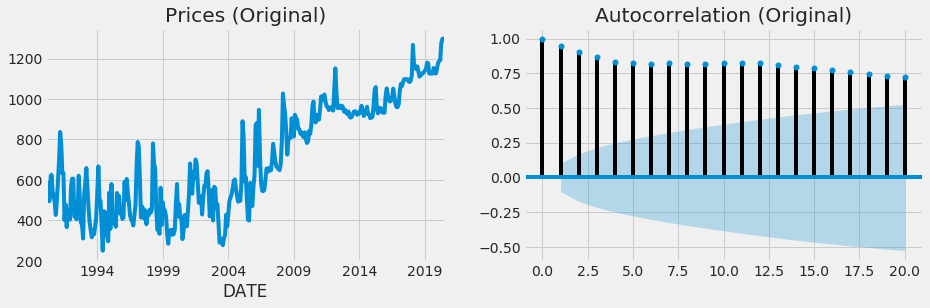

In [26]:
# Plot box plot and line plot of select countries in two subplots 
fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). 

# Subplot 1: 1st Order Differencing
banana['Banana Price'].plot(figsize=(14, 4), ax=ax0)
ax0.set_title('Prices (Original)')

# Subplot 2: Autocorrelation (Original)
plot_acf(banana['Banana Price'], lags=20, ax=ax1) 
ax1.set_title ('Autocorrelation (Original)')

plt.show()

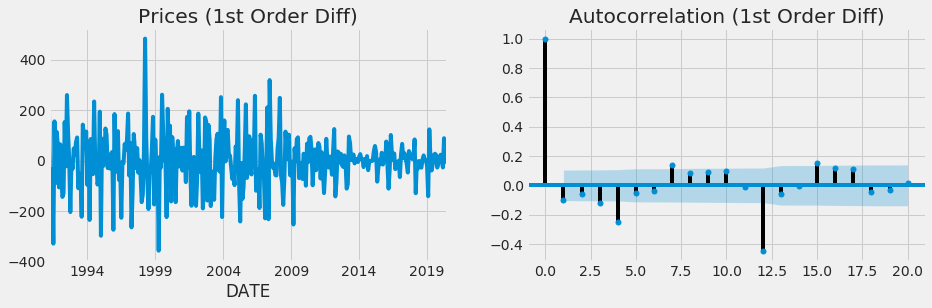

In [27]:
# Plot box plot and line plot of select countries in two subplots 
fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). 

# Subplot 1: 1st Order Differencing
banana_diff_1.plot(figsize=(14, 4), ax=ax0) 
ax0.set_title('Prices (1st Order Diff)')

# Subplot 2: Autocorrelation
plot_acf(banana_diff_1, lags=20, ax=ax1) 
ax1.set_title ('Autocorrelation (1st Order Diff)')

plt.show()

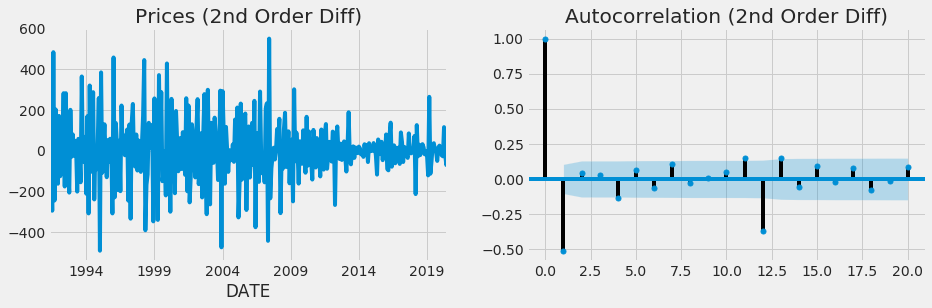

In [28]:
# Plot box plot and line plot of select countries in two subplots 
fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). 

# Subplot 1: 2nd Order Differencing
banana_diff_2.plot(figsize=(14, 4), ax=ax0) 
ax0.set_title('Prices (2nd Order Diff)')

# Subplot 2: Autocorrelation
plot_acf(banana_diff_2, lags=20, ax=ax1) 
ax1.set_title ('Autocorrelation (2nd Order Diff)')

plt.show()

Let's check that the 1st order diff is stationary by running an AD Fuller test. The null hypothesis is that there is a unit root for a series while the alternative is that it's stationary. If the p value is less than 0.05 (at 95% confidence), then we can reject the null and accept the alternative that the series is stationary. Below we see that the p-values is miniscule, our series is stationary. 

In [29]:
# Check that 1st order diff is stationary by running AD Fuller test.  
banana_diff_1_results = adfuller(banana_diff_1)

print('The p-value of the test is: ' + str(banana_diff_1_results[1]))

The p-value of the test is: 3.541068627837021e-11


### 5.3. Identify AR Order

Let's determine the order, or optimal lag length, of the AR (autoregressive) model by two methods: 1) partial autocorreation (PACF) and 2) information / goodness-of-fit criteria, specifically Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC). AIC and BIC both aim to simplify the model by penalizing overly complex (excessive orders) models. The goal is to minimize the AIC and BIC values. They often favor the same model, but, when they don't, you can choose the lowest AIC if you're looking for a better predictive model and BIC if you're looking for a better explanatory model. 

PACF determines the incremental benefit of adding another lag. In a PACF plot, the number of significant lags indicates the order of the AR model. From our PACF plot, it looks like there are about 8 lags that are significant. To avoid overfitting, let's stay on the conservative side and choose 6 lags (an AR(6) model). This is also confirmed by the AIC and BIC below, which are lowest at 6 lags. 

This means that the 'p' value for the ARIMA model later is 6. 

#### 5.3.1. PACF

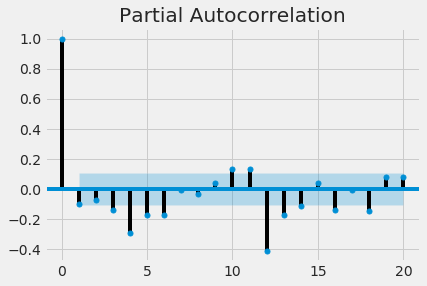

In [30]:
# PACF plot
plt.rcParams["figure.figsize"] = [6,4]
plot_pacf(banana_diff_1, lags=20)
plt.show()

#### 5.3.2. AIC and BIC

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency infor

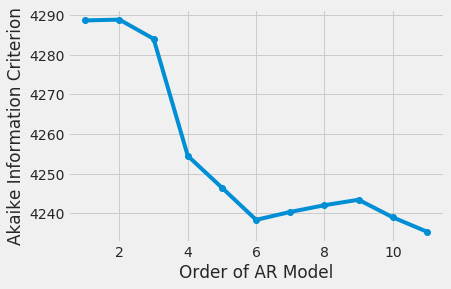

In [31]:
# Fit the data to an AR(p) for p = 0,...,12 , and save the AIC
AIC = np.zeros(12)
for p in range(12):
    mod = ARMA(banana_diff_1, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    AIC[p] = res.aic
    
# Plot the AIC as a function of p
plt.figure(figsize=(6,4))
plt.plot(range(1,12), AIC[1:12], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M

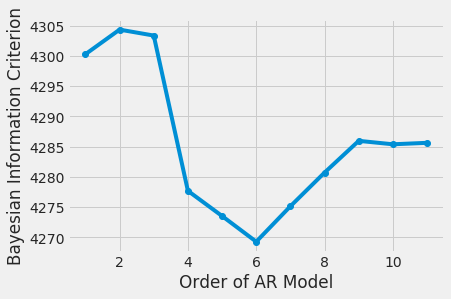

In [32]:
# Fit the data to an AR(p) for p = 0,...,12 , and save the BIC
BIC = np.zeros(12)
for p in range(12):
    mod = ARMA(banana_diff_1, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.figure(figsize=(6,4))
plt.plot(range(1,12), BIC[1:12], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [33]:
# Full summary of AR model (AIC, BIC values below, coefficients (phi) for each order also below)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Banana Price   No. Observations:                  353
Model:                    ARMA(11, 0)   Log Likelihood               -2104.691
Method:                       css-mle   S.D. of innovations             93.853
Date:                Thu, 03 Sep 2020   AIC                           4235.382
Time:                        14:23:59   BIC                           4285.646
Sample:                    03-01-1991   HQIC                          4255.382
                         - 07-01-2020                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0743      2.830      0.026      0.979      -5.473       5.622
ar.L1.Banana Price     -0.2573      0.053     -4.870      0.000      -0.361      -0.154
ar.L2.Banana Price     -0.2044      0.054     -3.786      0.000      -0.310      -0.099
ar.L3.Banana Price     -0.2254      0.055     -4.111      0.000      -0.333      -0.118
ar.L4.Banana Price     -0.3265      0.056     -5.817      0.000      -0.436      -0.216
ar.L5.Banana Price     -0.1532      0.059     -2.585      0.010      -0.269      -0.037
ar.L6.Banana Price     -0.0984      0.060     -1.650      0.100      -0.215       0.018
ar.L7.Banana Price      0.0696      0.059      1.173      0.242      -0.047       0.186
ar.L8.Banana Price      0.0388      0.057      0.681      0.496      -0.073       0.150
ar.L9.Banana Price      0.1002      0.055      1.805      0.072      -0.009       0.209
ar.L10.Banana Price     0.1661      0.055      3.046      0.003       0.059       0.273
ar.L11.Banana Price     0.1276      0.054      2.383      0.018       0.023       0.233
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.2234           -0.0000j            1.2234           -0.0000
AR.2             0.7986           -0.7173j            1.0734           -0.1165
AR.3             0.7986           +0.7173j            1.0734            0.1165
AR.4             0.4242           -1.1125j            1.1906           -0.1920
AR.5             0.4242           +1.1125j            1.1906            0.1920
AR.6            -0.3132           -1.1572j            1.1989           -0.2921
AR.7            -0.3132           +1.1572j            1.1989            0.2921
AR.8            -0.9481           -0.8475j            1.2717           -0.3839
AR.9            -0.9481           +0.8475j            1.2717            0.3839
AR.10           -1.2238           -0.4351j            1.2989           -0.4456
AR.11           -1.2238           +0.4351j            1.2989            0.4456
------------------------------------------------------------------------------
"""

### 5.4. Identify MA Order

Similar to how we used PACF of the 1st order differenced data to determine the AR model, we can use the ACF of the 1st order differenced data to determine the MA (moving average) as MA is essentially the error of the lagged forecast. The number of significant lags is the number of MA terms needed to remove autocorrelation in the staionary data. 

From our ACF plot, it looks like there are about 4 lags that are significant. To avoid overfitting, I'm going to stay on the conservative side and choose 2 lags (an MA(2) model). 

This means that the 'q' value for the ARIMA model later is 2. 

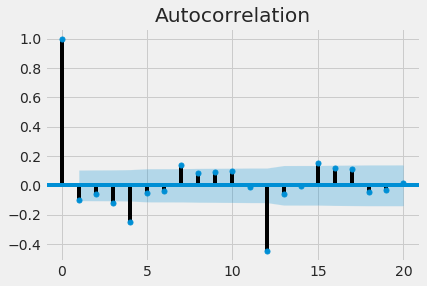

In [34]:
# PACF plot
plt.rcParams["figure.figsize"] = [6,4]
plot_acf(banana_diff_1, lags=20)
plt.show()

Note: If you believe the series is slightly under-differenced, you can add one or two more AR terms to make it up. Similarly, if you think the data is slightly over-differenced, you can add one or two more MA terms to make it up. 

## 6. Estimation

### 6.1. ARIMA 

The ARIMA (Autoregressive Integrated Moving Average) model below is just for illustrative purposes. Since the data is seasonal, we will have correlated residuals left if we fit an ARIMA model and, therefore, wouldn't be using all the information in the data. A SARIMA or SARIMAX model would fit our case, but let's first see what an ARIMA model produces. From building and evaluating the AR and MA models above, we have the order (p,d,q) of the ARIMA model as order=(6,1,2).

Notice that in the summary a couple of the AR coefficients are close to zero with high p-values ('P>z'). Ideally, we could improve the ARIMA by removing 2 lags for an AR(4).

In [35]:
# 6,1,2 ARIMA Model
mod = ARIMA(banana['Banana Price'], order=(6,1,2))
res = mod.fit(disp=0)
res.summary()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Banana Price   No. Observations:                  365
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -2083.555
Method:                       css-mle   S.D. of innovations             72.812
Date:                Thu, 03 Sep 2020   AIC                           4187.111
Time:                        14:24:01   BIC                           4226.110
Sample:                    03-01-1990   HQIC                          4202.610
                         - 07-01-2020                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8099      1.007      1.797      0.073      -0.164       3.784
ar.L1.D.Banana Price    -0.0689      0.146     -0.471      0.638      -0.356       0.218
ar.L2.D.Banana Price     0.3979      0.119      3.353      0.001       0.165       0.631
ar.L3.D.Banana Price    -0.0760      0.056     -1.351      0.178      -0.186       0.034
ar.L4.D.Banana Price    -0.2815      0.056     -4.989      0.000      -0.392      -0.171
ar.L5.D.Banana Price     0.0098      0.073      0.134      0.894      -0.134       0.153
ar.L6.D.Banana Price    -0.0695      0.071     -0.980      0.328      -0.208       0.069
ma.L1.D.Banana Price    -0.1461      0.139     -1.047      0.296      -0.419       0.127
ma.L2.D.Banana Price    -0.5707      0.130     -4.400      0.000      -0.825      -0.316
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1061           -0.5938j            1.2554           -0.4216
AR.2           -1.1061           +0.5938j            1.2554            0.4216
AR.3            1.0634           -0.7160j            1.2820           -0.0943
AR.4            1.0634           +0.7160j            1.2820            0.0943
AR.5            0.1130           -2.3544j            2.3571           -0.2424
AR.6            0.1130           +2.3544j            2.3571            0.2424
MA.1            1.2019           +0.0000j            1.2019            0.0000
MA.2           -1.4579           +0.0000j            1.4579            0.5000
-----------------------------------------------------------------------------
"""

The ARIMA model forecasts that banana prices will increase to 1,300 dollars per metric ton by 2025 (gray band is 95% confidence interval). We see that the ARIMA model doesn't account for the seasonality we have and forecasts a straight line. The SARIMA model further below captures seasonality. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


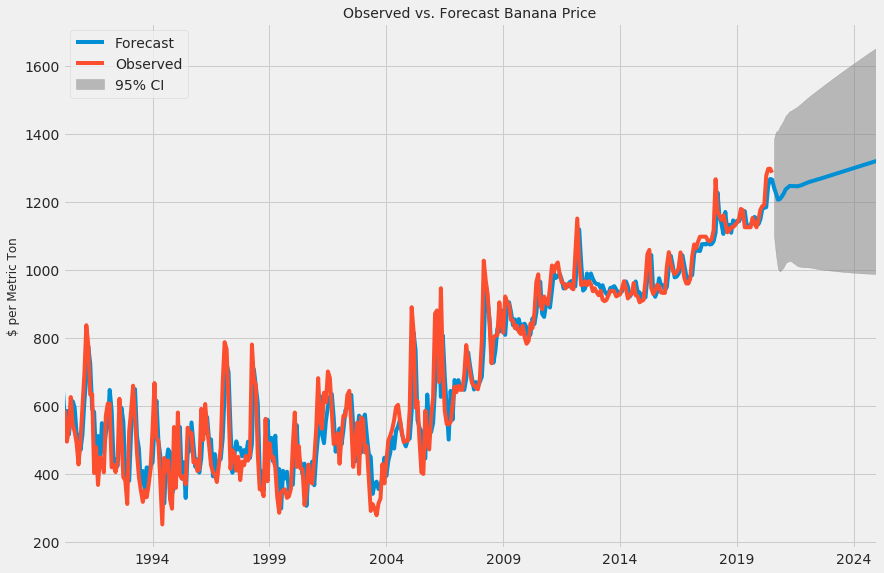

In [40]:
# Observed vs predicted and forecast

# Set figure size
plt.rcParams["figure.figsize"] = [13,9]

# Predict out to 2025
res.plot_predict(start='1990',end='2025')

# Plot
plt.title('Observed vs. Forecast Banana Price', fontsize=14)
plt.ylabel('$ per Metric Ton', fontsize=12)
plt.legend(loc='upper left', labels=['Forecast', 'Observed', '95% CI'])
plt.show()

### 6.2. SARIMA 

However, the ARIMA model above doesn't account for seasonality. Since we have a seasonal component, it makes more sense to apply a SARIMA (seasonal ARIMA) model, choosing p, d, q for ARIMA and P, D, Q for the seasonal component. 

Let's use auto_arima from pyramid-arima to automatically perform a grid search for p, d, q, P, D, Q values based on AIC and BIC scores. In the summary below, the optimal model generated is SARIMA(1,1,4)x(0,1,1,12) with an AIC of 4049 and a BIC of 4080.

In [41]:
# Instantiate SARIMA model
sarima = auto_arima(banana['Banana Price'], start_p=1, start_q=1,max_p=4, max_q=7, m=12,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True, d=1, D=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)
# Summary of results
sarima.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4290.270, BIC=4298.003, Fit time=0.035 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4198.910, BIC=4214.376, Fit time=0.831 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4096.364, BIC=4111.830, Fit time=0.676 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4098.038, BIC=4117.370, Fit time=0.894 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4287.913, BIC=4299.512, Fit time=0.195 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=4098.069, BIC=4117.401, Fit time=4.266 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4099.027, BIC=4122.226, Fit time=9.359 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  366
Model:             SARIMAX(1, 1, 4)x(0, 1, 1, 12)   Log Likelihood               -2016.599
Date:                            Thu, 03 Sep 2020   AIC                           4049.199
Time:                                    14:31:08   BIC                           4080.130
Sample:                                         0   HQIC                          4061.507
                                            - 366                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2962      0.225      1.318      0.188      -0.144       0.737
ar.L1         -0.4442      0.138     -3.210      0.001      -0.715      -0.173
ma.L1          0.1145      0.138      0.831      0.406      -0.156       0.385
ma.L2         -0.3000      0.067     -4.502      0.000      -0.431      -0.169
ma.L3         -0.1559      0.054     -2.885      0.004      -0.262      -0.050
ma.L4         -0.3255      0.051     -6.324      0.000      -0.426      -0.225
ma.S.L12      -0.9441      0.055    -17.294      0.000      -1.051      -0.837
sigma2      4900.4913    298.170     16.435      0.000    4316.090    5484.893
===================================================================================
Ljung-Box (Q):                       43.78   Jarque-Bera (JB):               116.86
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6.3. SARIMAX 

SARIMAX can do everything that ARMA, ARMAX, ARIMA, and SARIMA models can do and more. They can also incorporate exogenous variables (e.g., other data that could affect the time series such climate, supply shocks, etc.), though we won't be featuring exogenous variables here. 

In [42]:
# Instantiate SARIMAX model with the optimal orders we generated above. Include trend='c' as our mean is not centered around zero
best_model = SARIMAX(banana['Banana Price'], order=(1, 1, 4), seasonal_order=(0, 1, 1, 12), trend='c')

# Fit SARIMAX model
results=best_model.fit()

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## 7. Model Diagnostics

### 7.1. Plot Diagnostics

The plot of the model's diagnostics illustrate what we should expect from the residuals:

1) Standardized residual shows no obvious pattern (though we do see less variability in more recent years)
<br>2) The model distribution (red) is relatively close to a normal distribution (yellow)
<br>3) The normal QQ plot illustrates how close the distribution of the residuals compares to that of a normal distribution. Most points on the QQ plot lie on the line, though there is some curvature and notably stronger correlations on the higher and lower ends 
<br>4) In the correlogram (an ACF plot of the residuals), >95% of the correlations are not significant, meaning that we're using all the information in the data. 

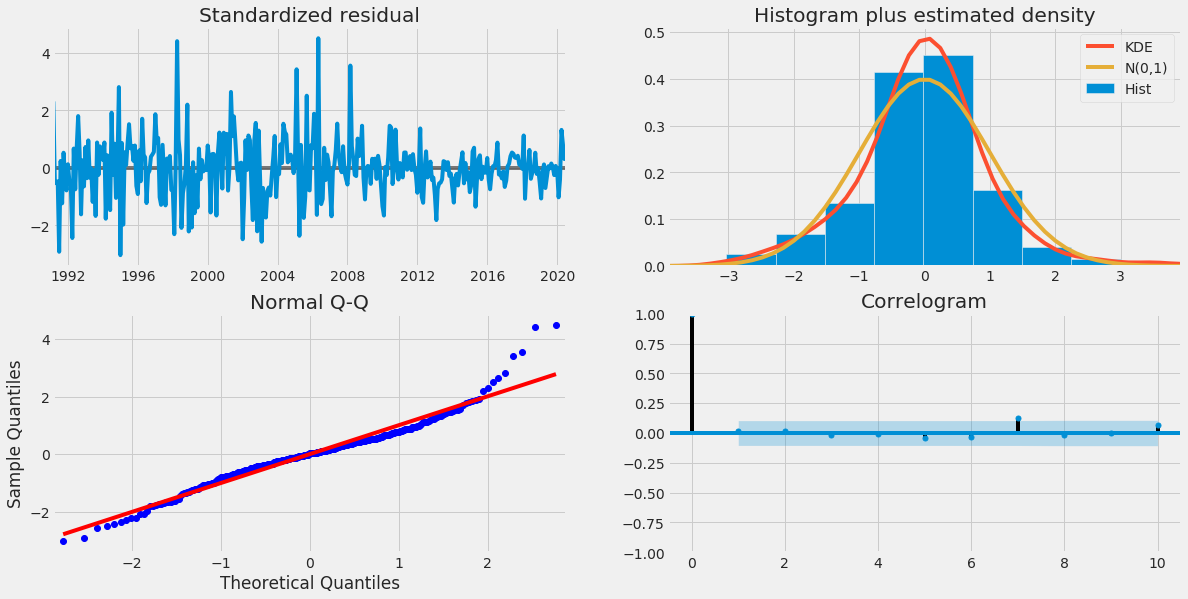

In [43]:
# Plot diagnostics 
results.plot_diagnostics(figsize=(18, 9))
plt.show()

### 7.2. SARIMAX Summary

In the summary below, except for one MA coefficient, we have fairly strong p-values. The Ljung Box(Q) test and its p-value Prob(Q) features the null hypothesis that the residuals are uncorrelated. If Prob(Q) is above 0.05, we can accept the null hypothesis that there are no correlations in the residual. If Prob(Q) is below 0.05, we reject the null hypothesis, meaning that there are correlations among residuals. The Jarque-Bera(JB) test and its p-value Prob(JB) features the null hypothesis that the residuals are normally distributed. If Prob(JB) is above 0.05, we can accept the null hypothesis that the residuals are normally distributed. If Prob(JB) is below 0.05, we reject the null hypothesis, meaning that residuals are not normally distibuted.  The Prob(JB) is below 0.05 indicating that the residuals are not normally distributed. This is an area of improvement we can look into in the future.

In [44]:
# Summary of SARIMAX results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       Banana Price   No. Observations:                  366
Model:             SARIMAX(1, 1, 4)x(0, 1, 1, 12)   Log Likelihood               -2016.599
Date:                            Thu, 03 Sep 2020   AIC                           4049.199
Time:                                    14:31:12   BIC                           4080.130
Sample:                                02-01-1990   HQIC                          4061.507
                                     - 07-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2962      0.225      1.318      0.188      -0.144       0.737
ar.L1         -0.4442      0.138     -3.210      0.001      -0.715      -0.173
ma.L1          0.1145      0.138      0.831      0.406      -0.156       0.385
ma.L2         -0.3000      0.067     -4.502      0.000      -0.431      -0.169
ma.L3         -0.1559      0.054     -2.885      0.004      -0.262      -0.050
ma.L4         -0.3255      0.051     -6.324      0.000      -0.426      -0.225
ma.S.L12      -0.9441      0.055    -17.294      0.000      -1.051      -0.837
sigma2      4900.4913    298.170     16.435      0.000    4316.090    5484.893
===================================================================================
Ljung-Box (Q):                       43.78   Jarque-Bera (JB):               116.86
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 7.3. Prediction (In-Sample)

In [45]:
# Let's drop the 'Monthly_Diff' column in our dataset as we don't need it anymore
banana.drop(columns='Monthly_Diff', inplace=True)

In the SARIMAX in-sample prediciton from 2016 onward below, SARIMAX is more accurate than ARIMA as it accounts for seasonality. 

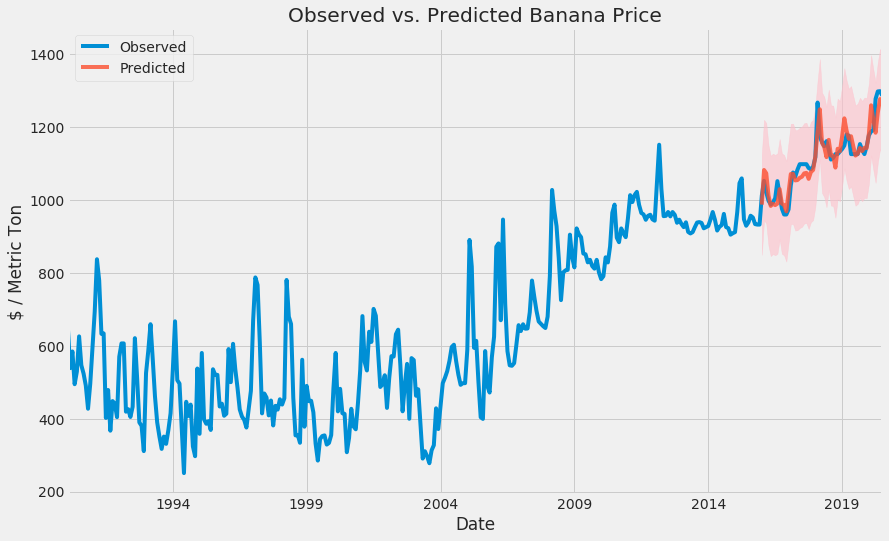

In [46]:
# Use SARIMAX model to predict banana price from 2016 onward
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)

# Variable for confidence interval using .conf_int()
pred_ci = pred.conf_int()

# Plot
ax = banana['1990':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.8, figsize=(13, 8))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=.6)
ax.set_xlabel('Date')
ax.set_ylabel('$ / Metric Ton')
plt.title('Observed vs. Predicted Banana Price')
plt.legend(loc='upper left', labels=['Observed','Predicted'])
plt.show()

#### 7.3.1. Evaluation

MAPE is the most useful in evaluating the quality of the model. MAPE below indicates that the average difference between the predicted value from the model and the historical observed value is 8.37%. In the future, in order to better evaluate, we should get context and appropriate errors and metrics from industry experts to understand what works best. Additionally, as MAPE has its own disadvantages, we could explore other evaluation criteria. 

In [47]:
# Mean of prediction and observed from 2016 to current
y_predicted = pred.predicted_mean
y_observed = banana['2016-01-01':]

# Calculate evaluation metrics
mse = mean_squared_error(y_observed,y_predicted)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_observed,y_predicted)

# MAPE not in scikitlearn, let's define it ourselves
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Print evaluation metrics
print('The Mean Squared Error (MSE) is {}'.format(mse))
print('The Root Mean Squared Error (RMSE) is {}'.format(rmse))
print('The Mean Absolute Error (MAE) is {}'.format(mae))
print('The Mean Absolute Percentage Error (MAPE) is {}'.format(mape(y_observed, y_predicted)))

The Mean Squared Error (MSE) is 1167.9746297921113
The Root Mean Squared Error (RMSE) is 34.17564380947506
The Mean Absolute Error (MAE) is 25.488006091164348
The Mean Absolute Percentage Error (MAPE) is 8.36901243895354


### 7.4. Forecast (Out-of-Sample)

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


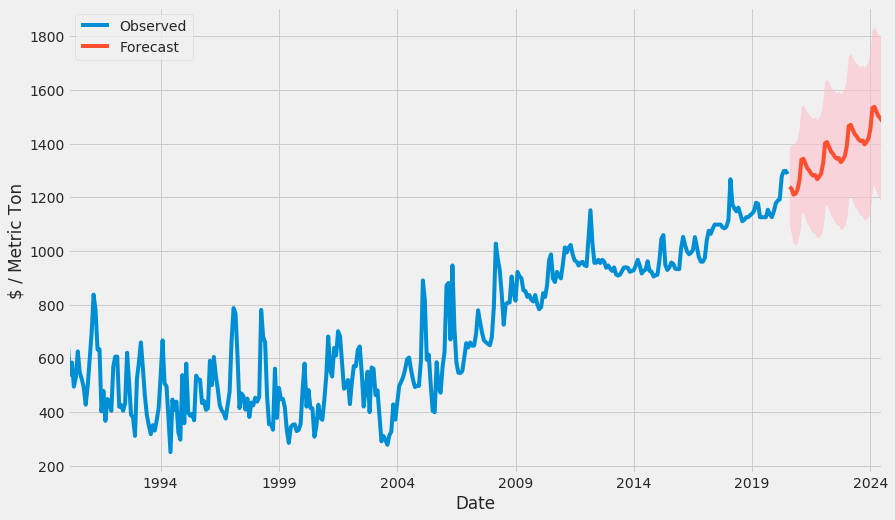

In [48]:
# Use SARIMAX model to forecast banana price for the next 48 months
forecast = results.get_forecast(steps=48)

# Variable for confidence interval using .conf_int()
forecast_ci = forecast.conf_int()

# Plot
ax = banana['Banana Price'].plot(label='Observed', figsize=(13, 8))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=.6)
ax.set_xlabel('Date')
ax.set_ylabel('$ / Metric Ton')
plt.legend(loc='upper left', labels=['Observed','Forecast'])
plt.show()

In [49]:
# Forecasted banana prices for the next 12 months
y_forecasted = forecast.predicted_mean
y_forecasted.head(12)

2020-08-01    1239.128646
2020-09-01    1231.253246
2020-10-01    1209.612298
2020-11-01    1213.258333
2020-12-01    1227.828704
2021-01-01    1263.849738
2021-02-01    1339.630459
2021-03-01    1343.172495
2021-04-01    1325.423801
2021-05-01    1307.960542
2021-06-01    1299.348610
2021-07-01    1286.792858
Freq: MS, dtype: float64

## 8. Production

Let's save our SARIMAX model for use in the future using joblib, a set of tools for lightweight Python pipelining, including transparent disk-caching and parallel computing. You can learn more about joblib here (https://pypi.org/project/joblib/) and here (https://joblib.readthedocs.io/en/latest/)

In [50]:
# Save our SARIMAX model so we can load and update it later with new data
filename = 'banana_price.pkl'
joblib.dump(best_model, filename)

['banana_price.pkl']

**To load the model in the future**:

from joblib import load
<br>loaded_model = joblib.load(filename)

**To update the model with new data**:

loaded_model.update(new_data)

## 9. Future Areas for Improvement

**Context**: get more context from industry experts to understand what constitutes a reasonable forecast error in this specific case. MAPE has its own disadvantages so consider other metrics that industry experts use 

**Distribution of Residuals**: As we saw above with the Jarque-Bera(JB) test and its low (<0.05) p-value Prob(JB) that residuals are not entirely normally distributed. We could also see this in the QQ plot. We could check if removing outliers improves this. 

**Stationarity**: Our differenced data is only weakly stationary. We can see this in the higher variance in the earlier part of the series. Apply and compare other log transform, n-level differencing, seasonal differencing, or square root adjustments. 

**Dynamic prediction and forecast**: Incorporated predicted / forecasted values (not just true endogenous values) into prediction and forecast. To do this, set dynamice=True in .get_prediction and .get_forecast, plot, and evaluate. 

**Incorporate exogenous variables**: Incorporate exogenous variables (e.g., climate, supply shocks, anomalies) into SARIMAX. 

**Compare**: Compare our forcaste mean prices with futures contracts

**Business Translation**: Translate the model selection/optimization rationale, evaluation metrics (e.g., MAPE), predictions and forecasts into specific business impact so that it's helpful to understand for a client / stakeholder. 